### Table of Contents

* [1ère partie : Analyse exploratoire de données](#chapter1)
    * [Imputation des valeurs nulles par interpolation](#section_1_1)
    * [Distribution des données dans un boxplot](#section_1_2)
    * [Gestion des outliers](#section_1_3)
    * [Nombre de vrais/faux billets](#section_1_4)
* [2ème partie : Analyse prédictive](#chapter2)
    * [Prédiction avec K-means](#section_2_1)
        * [Préparation et entraînement modèle](#section_2_1_1)
        * [Evaluations modèle](#section_2_1_2)
        * [Affichage résultat](#section_2_1_3)
    * [Prédiction avec Régression logistique](#section_2_2)
        * [Entraînement modèle](#section_2_2_1)
        * [Evaluations modèle](#section_2_2_2)
* [3ème partie : Mise en production](#chapter3)

### 1ère partie : Analyse exploratoire de données <a class="anchor" id="chapter1"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#pip install jupyterlab-spellchecker

In [3]:
billets = pd.read_csv("billets.csv", sep=";")

In [4]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### Imputation valeurs nulles par interpolation <a class="anchor" id="section_1_1"></a>

In [5]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
billets.isnull().values.any()

True

In [7]:
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [8]:
# On enlève d'abord la variable catégorielle cible
billets_bis = billets.drop(["is_genuine"], axis = 1)
billets_bis.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


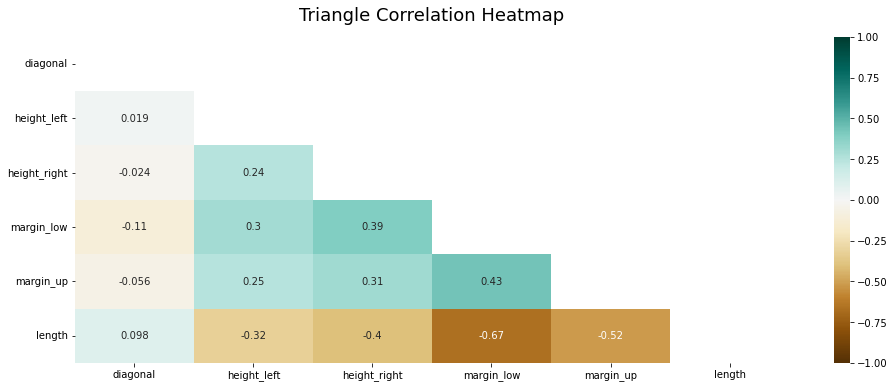

In [9]:
# Visualisation des corrélations dans un heatmap
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(billets_bis.corr(), dtype='bool'))
heatmap = sns.heatmap(billets_bis.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

In [10]:
billets.margin_low.interpolate(method='linear', inplace=True, limit_direction="both")
billets.isna().any()

is_genuine      False
diagonal        False
height_left     False
height_right    False
margin_low      False
margin_up       False
length          False
dtype: bool

####   Distribution des données dans un boxplot <a class="anchor" id="section_1_2"></a>

In [11]:
# Encore une fois, on retire la variable catégorielle pour créer notre boxplot
billets_dim = billets.drop(columns=['is_genuine'])
billets_dim.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


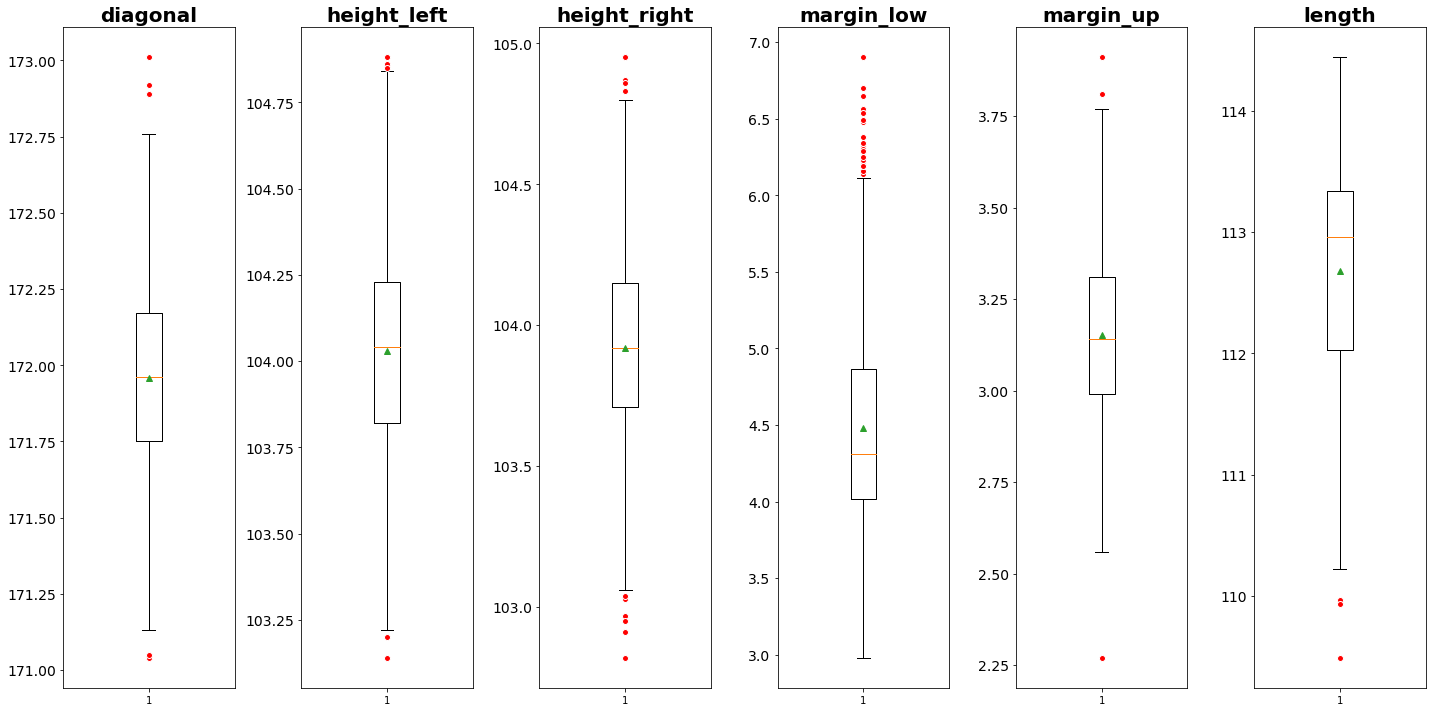

In [12]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(billets_dim.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(billets_dim.iloc[:,i], flierprops=red_circle, showmeans=True)
    ax.set_title(billets_dim.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

#### Gestion des outliers <a class="anchor" id="section_1_3"></a>

In [13]:
col = ['diagonal','height_left','height_right','margin_low','margin_up']

for x in col:
    q75,q25 = np.percentile(billets.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    billets.loc[billets[x] < min,x] = np.nan
    billets.loc[billets[x] > max,x] = np.nan

In [14]:
billets.isnull().sum()

is_genuine       0
diagonal         7
height_left      6
height_right    11
margin_low      25
margin_up        3
length           0
dtype: int64

In [15]:
#drop the null-value transformed outliers

billets = billets.dropna(axis=0)

Alternative to dropping : Capping the outlier rows with Percentiles

In [16]:
#pip uninstall feature_engine

In [17]:
'''from feature_engine.outliers import Winsorizer

windsorizer = Winsorizer(capping_method='quantiles',
                        tail = 'both',
                        fold=0.05
                        )
windsorizer.fit(billets)'''

"from feature_engine.outliers import Winsorizer\n\nwindsorizer = Winsorizer(capping_method='quantiles',\n                        tail = 'both',\n                        fold=0.05\n                        )\nwindsorizer.fit(billets)"

In [18]:
#billets = windsorizer.transform(billets)

In [19]:
billets.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [20]:
billets_dim = billets.drop(columns=['is_genuine'])
billets_dim

,diagonal,height_left,height_right,margin_low,margin_up,length
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
5,172.17,103.74,104.08,4.42,2.95,112.81
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


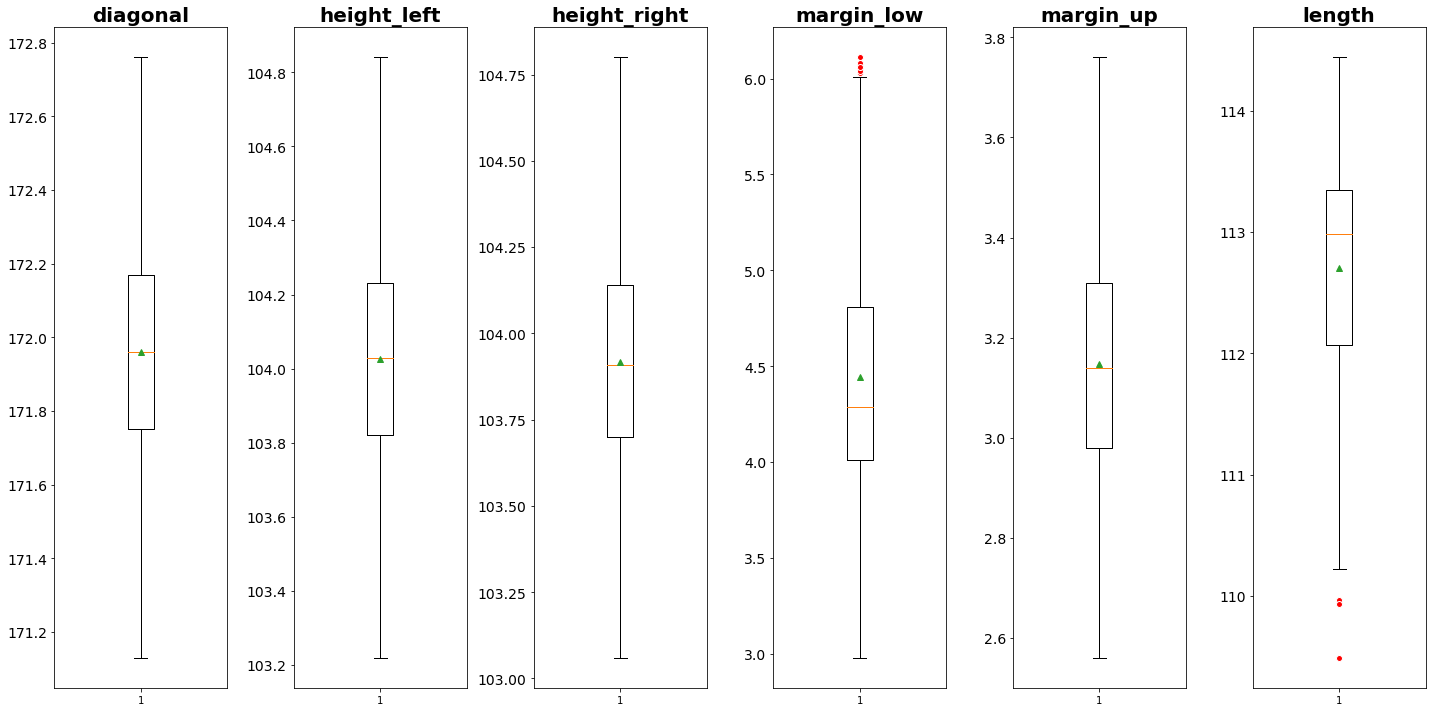

In [21]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(billets_dim.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(billets_dim.iloc[:,i], flierprops=red_circle, showmeans=True)
    ax.set_title(billets_dim.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

#### Nombre de vrais/faux billets <a class="anchor" id="section_1_4"></a>

In [22]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
5,True,172.17,103.74,104.08,4.42,2.95,112.81


In [23]:
billets.groupby(['is_genuine'])['is_genuine'].count()

is_genuine
False    462
True     987
Name: is_genuine, dtype: int64

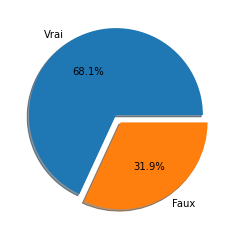

In [24]:
labels = "Vrai","Faux"
size = [987,462]

fig1, ax1 = plt.subplots()
explode = (0,0.1)
ax1.pie(size, explode =explode, labels=labels, autopct='%1.1f%%', shadow=True)

plt.show()

### 2ème partie : Analyse prédictive <a class="anchor" id="chapter2"></a>

#### Prédiction avec K-means  <a class="anchor" id="section_2_1"></a>

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

##### Préparation et entraînement modèle <a class="anchor" id="section_2_1_1"></a>

In [26]:
# Create Numpy arrays

data = billets.drop(columns=['is_genuine'])

true_label_names = billets["is_genuine"]

In [27]:
# We parse labels to integers for future evaluation of the kmeans

label_encoder = LabelEncoder()

true_labels = label_encoder.fit_transform(true_label_names)

true_labels[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [28]:
#Show the classes

label_encoder.classes_

array([False,  True])

In [29]:
#Store arrays in new variable

n_clusters = len(label_encoder.classes_)

In [30]:
# We reduce dimensions with PCA

preprocessor = Pipeline(
    [
    ("scaler", MinMaxScaler()),
    ("pca", PCA(n_components=2,random_state=42)),
    ]
)

In [31]:
# Build the pipeline

clusterer = Pipeline(
    [
        ("kmeans", KMeans(
        n_clusters=n_clusters,
        init="k-means++",
        n_init=50,
        max_iter=500,
        random_state=42),
        ),
    ])

In [32]:
# Build larger pipeline

pipe = Pipeline(
    [
        ("preprocessor",preprocessor),
        ("clusterer",clusterer),
    ]
)

In [33]:
# Fit pipeline to data

pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=2, n_init=50,
                                         random_state=42))]))])

##### Evaluations modèle <a class="anchor" id="section_2_1_2"></a>

In [34]:
# Evaluate performance of k-means with silhouette coefficient

preprocessed_data = pipe["preprocessor"].transform(data)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.5400265834102571

In [35]:
# Evaluate performance of k-means with ARI (Adjusted Rand Indicator)

adjusted_rand_score(true_labels, predicted_labels)

0.9282401813644489

##### Affichage résultat <a class="anchor" id="section_2_1_3"></a>

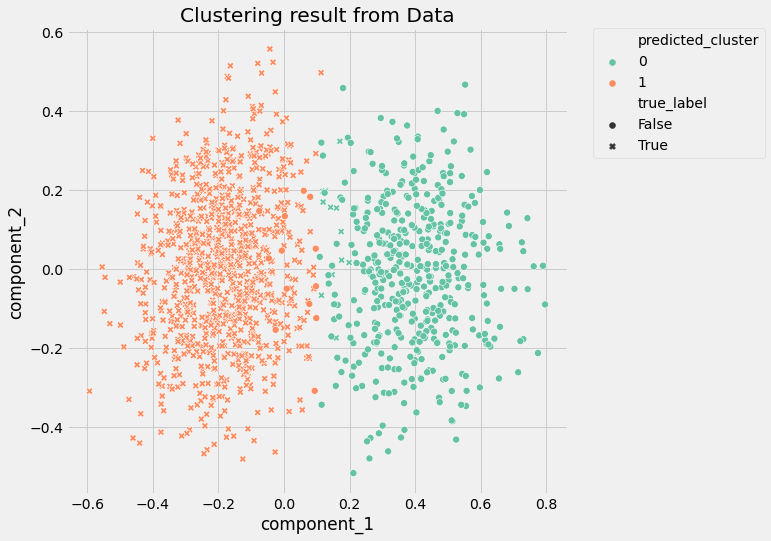

In [36]:
# Plot the resulting K-means

pcadf =pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns =["component_1","component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,8))

scat = sns.scatterplot(
    x="component_1",
    y="component_2",
    s=50,
    data=pcadf,
    hue ="predicted_cluster",
    style ="true_label",
    palette="Set2",
)

scat.set_title("Clustering result from Data")
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.0)
plt.show()

In [37]:
# Determine optimal number of principal components to "capture" maximum variance of data

# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 7):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

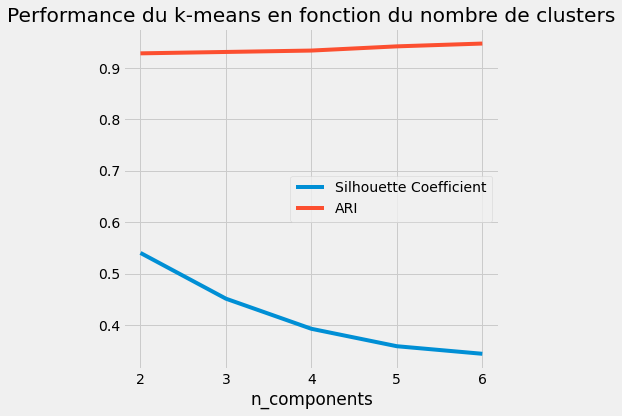

In [38]:
# Vislualise relationship between adding component and k-means performance

plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 7),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 7), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Performance du k-means en fonction du nombre de clusters")
plt.tight_layout()
plt.show()

***Le coefficient de silhouette indique que deux dimensions sont optimales : deux composantes principales donnent une meilleure représentativité des données. \
Le Score en Rang Ajusté indique que quelle que soit le nombre de composantes principales qu'on choisi, les labels (Vrai/Faux) sont correctement assignés aux clusters - à plus de 90%.***

***On peut aussi évaluer la performance de notre modèle avec une matrice de confusion***

In [39]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(predicted_labels, true_labels)

print(cf_matrix)

[[449  13]
 [ 13 974]]


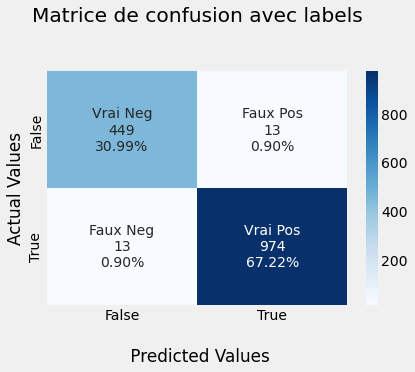

In [40]:
# Visu dans un heatmap

group_names = ["Vrai Neg","Faux Pos","Faux Neg","Vrai Pos"]

group_counts = ["{0:0.0f}".format(value) for value in
               cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
         zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Matrice de confusion avec labels\n\n');
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

#### Prédiction avec Régression logistique <a class="anchor" id="section_2_2"></a>

In [41]:
# On sépare la variable Feature de la variable Target

X = billets.drop(columns = 'is_genuine')
y = billets['is_genuine']

Mise à l'échelle : surtout nécessaire pour le k-means et KNN \
Normalisation : \
Nécessaire de traiter les outliers avant car l'effet de la réduction de l'écart-type leur donne plus d'impact \
Standardisation: \
corrige l'effet de réduction ; moins d'impact sur les outliers

In [42]:
#X = (X - X.mean()) / X.std()

In [43]:
# On sépare le training_set et le testing_set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [44]:
# Standardisation
'''from sklearn.preprocessing import StandardScaler

sc_train = StandardScaler()
X_train = sc_train.fit_transform(X_train)
y_train = sc_train.fit_transform(y_test)'''

'from sklearn.preprocessing import StandardScaler\n\nsc_train = StandardScaler()\nX_train = sc_train.fit_transform(X_train)\ny_train = sc_train.fit_transform(y_test)'

##### Entraînement modèle <a class="anchor" id="section_2_2_1"></a>

In [45]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

##### Evaluations modèle <a class="anchor" id="section_2_2_2"></a>

In [46]:
# Evaluation avec Cross-Validation

from sklearn.model_selection import cross_val_score

cross_val_score(logreg, X_train, y_train, cv=3, scoring='accuracy')

array([0.99171271, 0.98066298, 0.99171271])

In [47]:
# Confusion matrix is better to evaluate performance

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(logreg, X_train, y_train, cv=3)

Si l'on utilise trop de 'cv', cela risque d'imputer sur la variance (donc overfitting); si l'on n'en utilise pas assez, on impute le biais(donc underfitting); une bonne balance se situe à 3 k-folds/cv

In [48]:
#from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_train, y_train_pred)
cnf_matrix

array([[332,  11],
       [  2, 741]], dtype=int64)

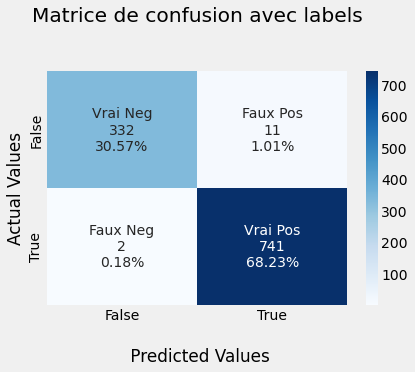

In [49]:
group_names = ["Vrai Neg","Faux Pos","Faux Neg","Vrai Pos"]

group_counts = ["{0:0.0f}".format(value) for value in
               cnf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                    cnf_matrix.flatten()/np.sum(cnf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
         zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Matrice de confusion avec labels\n\n');
ax.set_xlabel('\n Predicted Values')
ax.set_ylabel('Actual Values');

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

Evaluations de la matrice

In [50]:
from sklearn import metrics

print('Precision=', metrics.precision_score(y_train, y_train_pred))
print('Recall=', metrics.recall_score(y_train, y_train_pred))

Precision= 0.9853723404255319
Recall= 0.9973082099596231


***La précision indique que le modèle prédit juste, i-e: quand il prédit qu'un billet est vrai, il vise juste 98,5% du temps \
Le rappel indique que le modèle détecte correctement les instances positives, i-e: il détecte 99,7% des billets vrais***

In [51]:
# F1 score: mix de précision et recall

from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.9913043478260869

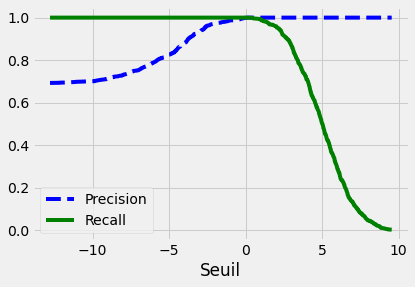

In [52]:
# plotting the precision vs recall tradeoff

y_scores = cross_val_predict(logreg, X_train, y_train, cv=3, method='decision_function')

# Compute the threshold
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_pred, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Seuil')
    [...]
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

Fonction d'Efficacité du Récepteur (ou ROC : Receiver Operating Characteristic)

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train, y_scores)
auc = roc_auc_score(y_train, y_scores)

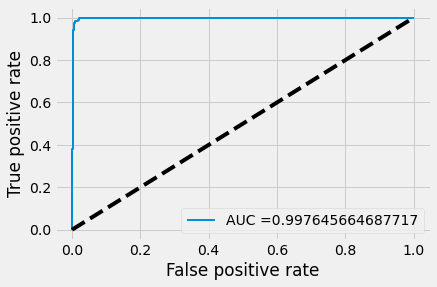

In [54]:
def plot_roc_curve(fpt, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label="AUC ="+str(auc))
    plt.plot([0,1], [0,1], 'k--')
    #plt.plot(label="data 1, auc="+str(auc))
    plt.legend(loc=4)

plot_roc_curve(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

***Ce graphique mesure les taux des vrais positifs contre les faux positifs; plus la courbe bleue s'approche du coin supérieur gauche, plus la classification est bonne ; quant à l'AUC (Area Under the Curve), plus il est proche de 1, plus le classificateur est digne de confiance***

### 3ème partie : Mise en production <a class="anchor" id="chapter3"></a>

In [55]:
billets_prod = pd.read_csv('billets_test.csv')

In [56]:
billets_prod_num = billets_prod.drop(columns='id')

In [57]:
billets_prod_num["is_genuine"] = pipe.predict(billets_prod_num).astype('bool')
id_prod = billets_prod["id"]
billets_prod = pd.concat((id_prod, billets_prod_num), axis=1)
billets_prod

,id,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine
0,B_1,172.09,103.95,103.73,4.39,3.09,113.19,True
1,B_2,171.52,104.17,104.03,5.27,3.16,111.82,False
2,B_3,171.78,103.80,103.75,3.81,3.24,113.39,True
3,B_4,172.02,104.08,103.99,5.57,3.30,111.10,False
4,B_5,171.79,104.34,104.37,5.00,3.07,111.87,False


**Exportation csv**

In [58]:
#billets_prod.to_csv('billets_prod', sep=';')

**Sources :**\
\
Réaliser des boxplots à l'échelle \
https://towardsdatascience.com/creating-boxplots-of-well-log-data-using-matplotlib-in-python-34c3816e73f4 \
Feature Engineering \
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114#3abe \
Gestion des outliers \
https://www.askpython.com/python/examples/detection-removal-outliers-in-python \
K-means clustering \
https://realpython.com/k-means-clustering-python/ \
Réaliser une matrice de confusion \
https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/ \
Régression logistique \
https://www.datacamp.com/tutorial/understanding-logistic-regression-python \